## Analyse the SWH and wind of ECMWF S5 and extended range for use in a seamless online dashboard


#### 0. Load modules and define some working directories

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import sys,os,glob
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import linregress
import xskillscore as xs
import properscoring as ps
#from bias_correction import BiasCorrection
import random
import xrscipy.signal as dsp
#import cartopy.crs as ccrs
#from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.dates as mdates

In [3]:
bd = '/where/is/the/raw/data/stored/'
bdf = '/where/do/I/save/my/figs/'
#bdapp = bd+'data_for_app/'
bd_s5 = bd+'s5/'
bd_era5 = bd+'era5/'
bd_ext = bd+'ext/'
bd_app = bd+'data_app/'   # Data needed for the application

### 1. Load the data

#### 1.1 Load S5 forecasts / hindcasts

In [4]:
filez_s5 = sorted(glob.glob(bd_s5+'*_wp.nc'))
valid_timez_s5= []
for fil in filez_s5:
    tmp = xr.open_dataset(fil,engine='netcdf4').load()
    valid_timez_s5.append(tmp.time.values)
    tmp = tmp.assign_coords(time=np.arange(len(tmp.time))).rename({'time':'step'})
    tmp = tmp.assign_coords(time=valid_timez_s5[-1][0])
    
    if fil == filez_s5[0]:
        swh_s5 = tmp
    else:
        swh_s5 = xr.concat([swh_s5,tmp],dim='time')
        
# There are some nans in the data due to unstable regridding at ECMWF (my guess), fix with interpolate_na
swh_s5 = swh_s5.interpolate_na(dim='step',method='quadratic',limit=3)
        
swh_s5.to_netcdf(bd_app+'swh_wind_s5_1981_2020.nc')

#### 1.2 Load extended range [0-46 days]

In [5]:
filez_ext = sorted(glob.glob(bd_ext+'ecmwf_extfc_swh_wind_wp_*.nc'))
valid_timez_ext = []

for fil in filez_ext:
    tmp2 = xr.open_dataset(fil).load()
    valid_timez_ext.append(tmp2.time.values)
    
    tmp2 = tmp2.assign_coords(time=np.arange(len(tmp2.time))).rename({'time':'step'})
    tmp2 = tmp2.assign_coords(time=valid_timez_ext[-1][0])
    
    if fil == filez_ext[0]:
        swh_ext = tmp2
    else:
        swh_ext = xr.concat([swh_ext,tmp2],dim='time')
# Save timedelta's for future 
tmp2 = xr.open_dataset(fil).load()        
valid_timez_ext_td = np.hstack([np.array(0,dtype='timedelta64'),tmp2.time.values[1:] - tmp2.time.values[:-1]])
#np.hstack([np.array(0,dtype='timedelta64'),valid_timez_ext_td])
swh_ext = swh_ext.drop(['latitude','longitude'])
swh_ext.to_netcdf(bd_app+'swh_ext_2017_2020.nc')

#### 1.3 Load ERA5 

In [6]:
filez_swh_era5 = sorted(glob.glob(bd_era5+'era5_secliferm_swh_*_wp.nc'))
era5_wp = xr.open_mfdataset(filez_swh_era5,combine='by_coords').load()
era5_wp.to_netcdf(bd_app+'swh_era5_1981_2020.nc')

### 2. Deal with variables on different time steps (hourly / 3-hourly / 6-hourly / daily

- ERA5 is hourly data
- Ext is hourly for first 90 hours, then jumps to 3-hourly up to 144 hours, then to 6-hourly240 by 6
- S5 is daily data

All data are instantanious values, so daily data will have an underestimation of SWH and wind speed over the day. We need to correct for this. A relative simple method to do is is to interpolate the 3hr, 6hr and 24hr data to hourly using spline interpolation.

#### 2.1 Assess the impact of using instantanious data
In order to test how well this works, we create 3hr, 6hr and 24hr instantaneous data (to recreate ext and s5 data), and then interpolate this data to hourly using spling interpolation (2nd order). From this hourly data we create 3, 6 and 24hr hourly max. If this x-hourly max correlates better with the actual x-hourly maximum, we improved the results. 

In [7]:
# First create daily max data and try to recreate with the 00UTC data and spline interpolation
era5_wp_dmax = era5_wp.resample(time='D').max('time')
era5_test = era5_wp.sel(time=era5_wp['time.hour']==0).sel(time=slice('2010','2020')).resample(time='1H')
era5_test_0d = era5_test.interpolate('zero').resample(time='D').max('time')
era5_test_1d = era5_test.interpolate('slinear').resample(time='D').max('time')
era5_test_2d = era5_test.interpolate('quadratic').resample(time='D').max('time')
era5_test_3d = era5_test.interpolate('cubic').resample(time='D').max('time')

era5_wp_3h = era5_wp.sel(time=slice('2010','2020')).resample(time='3h')
era5_wp_3hmax = era5_wp_3h.max() # What where really interested in
era5_wp_3hnear = era5_wp_3h.nearest() # Simulate 3-hourly ext range
era5_ext_3h_test = era5_wp_3hnear.resample(time='1H').interpolate('slinear').resample(time='3h').max('time')

era5_wp_6h = era5_wp.sel(time=slice('2010','2020')).resample(time='6h')
era5_wp_6hmax = era5_wp_6h.max()
era5_wp_6hnear = era5_wp_6h.nearest()
era5_ext_6h_test = era5_wp_6hnear.resample(time='1H').interpolate('slinear').resample(time='6h').max('time')

Calculate the linear regression between era5 dmax data, and era5 dmax from 00UTC data. There is still a general underestimation of daily max wind and swh (see figure below), and we need to correct for this. Possible future improvements: (1) force fit to origin and allow for a non-linear fit

In [8]:
def linregrez(x,y,dim='time'):
    b = xr.cov(x,y,dim=dim) / x.var(dim=dim)
    a = y.mean(dim=dim) - b * x.mean(dim=dim)
    return(xr.merge([a.to_dataset(name='alpha'),b.to_dataset(name='beta')]))
    
era5_swh_lr_dmax_fit1d = linregrez(era5_test_1d.swh,era5_wp_dmax.swh)
era5_wind_lr_dmax_fit1d = linregrez(era5_test_1d.wind,era5_wp_dmax.wind)

era5_test_1d_fit = xr.merge([
    (era5_test_1d.swh * era5_swh_lr_dmax_fit1d.beta + era5_swh_lr_dmax_fit1d.alpha).to_dataset(name='swh'),
    (era5_test_1d.wind * era5_wind_lr_dmax_fit1d.beta + era5_wind_lr_dmax_fit1d.alpha).to_dataset(name='wind')])


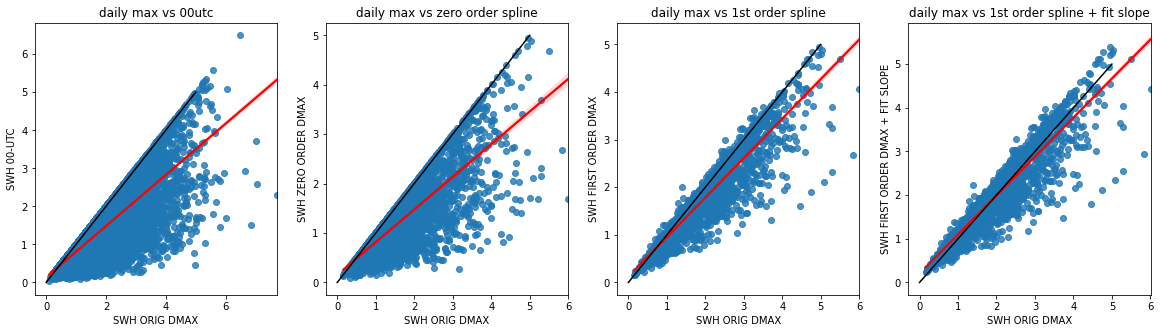

In [9]:
f,axs = plt.subplots(1,4,figsize=(20,5))
tmp = xr.merge([
    era5_wp_dmax.swh.sel(loc='Borssele').to_dataset(name='SWH ORIG DMAX'),
    era5_test_0d.swh.sel(loc='Borssele').to_dataset(name='SWH ZERO ORDER DMAX'),    
    era5_test_1d.swh.sel(loc='Borssele').to_dataset(name='SWH FIRST ORDER DMAX'),
    era5_test_2d.swh.sel(loc='Borssele').to_dataset(name='2nd order'),
    era5_test_3d.swh.sel(loc='Borssele').to_dataset(name='3rd order'),
    era5_test_1d_fit.swh.sel(loc='Borssele').to_dataset(name='SWH FIRST ORDER DMAX + FIT SLOPE'),
    era5_wp.sel(loc='Borssele',time=era5_wp['time.hour']==0).swh.to_dataset(name='SWH 00-UTC'),
    ]).to_dataframe()

cor = tmp.corr()

sns.regplot(x="SWH ORIG DMAX", y="SWH 00-UTC", data=tmp,ax=axs[0],line_kws = {'color': 'red'})
axs[0].set_title('daily max vs 00utc')
sns.regplot(x="SWH ORIG DMAX", y="SWH ZERO ORDER DMAX", data=tmp,ax=axs[1],line_kws = {'color': 'red'})
axs[1].set_title('daily max vs zero order spline')
sns.regplot(x="SWH ORIG DMAX", y="SWH FIRST ORDER DMAX", data=tmp,ax=axs[2],line_kws = {'color': 'red'})
axs[2].set_title('daily max vs 1st order spline')
sns.regplot(x="SWH ORIG DMAX", y="SWH FIRST ORDER DMAX + FIT SLOPE", data=tmp,ax=axs[3],line_kws = {'color': 'red'})
axs[3].set_title('daily max vs 1st order spline + fit slope')

for ax in axs:
    ax.plot(np.arange(6),color='k')
plt.savefig(bdf+'spline_interp_24hr_swh.png')

To conclude from this figure: Spline interpolation on 24hr inst. data does improve the estimate of daily max data, in comparison to 00UTC data. 1st, 2nd or 3rd order doesn't really matter that much, for further tests I'll just use 1st order. Note that there is still a systematic underestimation of SWH. Hence we need to correct for this as well

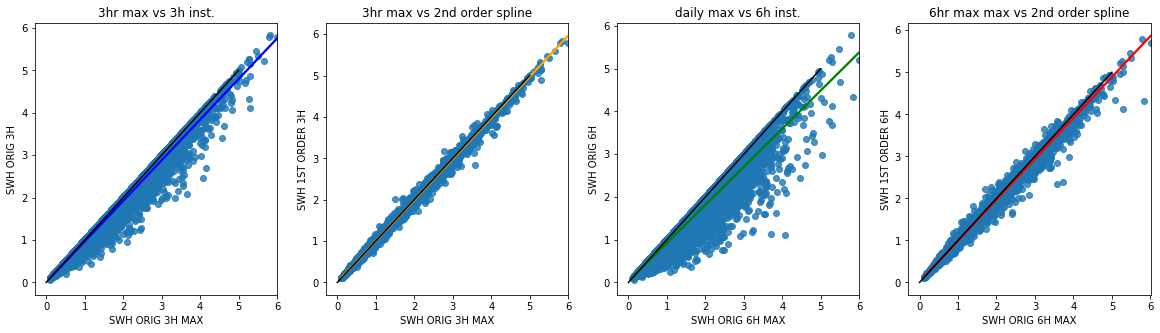

In [10]:
f,axs = plt.subplots(1,4,figsize=(20,5))
tmp = xr.merge([
    era5_wp_3hmax.swh.sel(loc='Borssele').to_dataset(name='SWH ORIG 3H MAX'),
    era5_wp_6hmax.swh.sel(loc='Borssele').to_dataset(name='SWH ORIG 6H MAX'),    
    era5_wp_3hnear.swh.sel(loc='Borssele').to_dataset(name='SWH ORIG 3H'),
    era5_wp_6hnear.swh.sel(loc='Borssele').to_dataset(name='SWH ORIG 6H'),    
    era5_ext_3h_test.swh.sel(loc='Borssele').to_dataset(name='SWH 1ST ORDER 3H'),
    era5_ext_6h_test.swh.sel(loc='Borssele').to_dataset(name='SWH 1ST ORDER 6H'),
    ]).to_dataframe()

cor = tmp.corr()

sns.regplot(x="SWH ORIG 3H MAX", y="SWH ORIG 3H", data=tmp,ax=axs[0],line_kws = {'color': 'blue'})
axs[0].set_title('3hr max vs 3h inst.')
sns.regplot(x="SWH ORIG 3H MAX", y="SWH 1ST ORDER 3H", data=tmp,ax=axs[1],line_kws = {'color': 'orange'})
axs[1].set_title('3hr max vs 2nd order spline')
sns.regplot(x="SWH ORIG 6H MAX", y="SWH ORIG 6H", data=tmp,ax=axs[2],line_kws = {'color': 'green'})
axs[2].set_title('daily max vs 6h inst.')
sns.regplot(x="SWH ORIG 6H MAX", y="SWH 1ST ORDER 6H", data=tmp,ax=axs[3],line_kws = {'color': 'red'})
axs[3].set_title('6hr max max vs 2nd order spline')

for ax in axs:
    ax.plot(np.arange(6),color='k')
plt.savefig(bdf+'spline_interp_3h6h_swh.png')

To conclude from this figure: For 3hr and 6hr data the spline interpolation works very nice, removing the standard bias en reducing the spread.

#### 2.2 Transform ext and S5 from instantanious data to maximum data over the specific time step used

For S5 is it quite easy to transform all data to 1hr and then compute 24hr max, just add a timedelta dimension and resample

In [11]:
swh_s5_1hr = swh_s5.assign_coords(step=pd.to_timedelta(np.arange(216), unit='d')).resample(step='1H',skipna=True).interpolate('slinear')
swh_s5_max = swh_s5_1hr.resample(step='D',skipna=True).max('step')
# Correct for average bias as a function of wave height, based on ERA5. This bias can be considerable
# for calculating maximum hourly values per 24hrs based on only O0UTC instantaneous values.
swh_s5_max = xr.merge([
    (swh_s5_max.swh * era5_swh_lr_dmax_fit1d.beta + era5_swh_lr_dmax_fit1d.alpha).to_dataset(name='swh'),
    (swh_s5_max.wind * era5_wind_lr_dmax_fit1d.beta + era5_wind_lr_dmax_fit1d.alpha).to_dataset(name='wind')])

del(swh_s5_1hr) # High memory usage, so delete..
# Remove last day of the forecasts because the values are lower due to the hourly resampling
swh_s5_max = swh_s5_max.isel(step=slice(None,-1))

For extended range it is a bit more difficult. Resample needs a monotonic increasing time axis, so we need to split the data up into hourly, 3 hourly and 6 hourly data, and then perform the resampling. 

In [12]:
# Convert the 'step' dimension to 'timedelta' in order to be able to use the resample method
swh_ext = swh_ext.assign_coords(step=valid_timez_ext[0]-valid_timez_ext[0][0])
swh_ext_3hr = swh_ext.sel(step=valid_timez_ext_td.astype('int')==10800e9).resample(step='1H').interpolate('slinear')
swh_ext_6hr = swh_ext.sel(step=valid_timez_ext_td.astype('int')>10800e9).resample(step='1H').interpolate('slinear')

swh_ext_max = xr.concat([swh_ext.sel(step=valid_timez_ext_td.astype('int')<10800e9),
                         swh_ext_3hr.resample(step='3H').max('step'),
                         swh_ext_6hr.resample(step='6H').max('step')],dim='step')

# Remove last day of the forecasts because the values are lower due to the hourly resampling
swh_ext_max = swh_ext_max.isel(step=slice(None,-1))

### 3 Some preliminary analysis of how good the forecasts are

#### 3.1 Rewrite ERA5 to same format as S5 and extended range, make it much easier to compute skill scores / biases

In [13]:
for i,(t,vt) in enumerate(zip(swh_s5_max.time,valid_timez_s5[:-1])):
    vt = vt[:-1] # remove last day of forecast
    try: # Add try because the forecasts contain future data while ERA5 does not, catch this error
        era5_ss = era5_wp_dmax.sel(time=vt)
    except KeyError: 
        continue
    tmp = era5_ss.rename({'time':'step'}).assign_coords(step=swh_s5_max.step.values).assign_coords(time=t)
    if i == 0:
        era5_s5 = tmp
    else:
        era5_s5 = xr.concat([era5_s5,tmp],dim='time')

for i,(t,vt) in enumerate(zip(swh_ext_max.time,valid_timez_ext)):
    try: # Add try because the forecasts contain future data while ERA5 does not, catch this error
        vt = vt[:-1] # Remove last day
        era5_ss = xr.concat([
            era5_wp.sel(time=vt[valid_timez_ext_td[:-1].astype('int')<10800e9]),
            era5_wp_3hmax.sel(time=vt[valid_timez_ext_td[:-1].astype('int')==10800e9]),
            era5_wp_6hmax.sel(time=vt[valid_timez_ext_td[:-1].astype('int')>10800e9])],dim='time')
        era5_ss2 = xr.concat([
            era5_wp.sel(time=vt[valid_timez_ext_td[:-1].astype('int')<10800e9]),
            era5_wp.sel(time=vt[valid_timez_ext_td[:-1].astype('int')==10800e9]),
            era5_wp.sel(time=vt[valid_timez_ext_td[:-1].astype('int')>10800e9])],dim='time')
        
        
        
    except KeyError: 
        continue
    tmp = era5_ss.rename({'time':'step'}).assign_coords(step=swh_ext_max.step.values).assign_coords(time=t)
    tmp2 = era5_ss2.rename({'time':'step'}).assign_coords(step=swh_ext_max.step.values).assign_coords(time=t)
    
    if i == 0:
        era5_ext = tmp
        era5_ext2 = tmp2
    
    else:
        era5_ext = xr.concat([era5_ext,tmp],dim='time')
        era5_ext2 = xr.concat([era5_ext2,tmp2],dim='time')
    

#### 3.2 Bias analysis

#### 3.2.1 Bias over leadtime

Calculate the bias and bias correct per month (to include seasonal effects of the bias)

In [14]:
bias_s5 = (swh_s5_max.mean(dim='number') - era5_s5)
bias_ext = (swh_ext_max.mean(dim='number') - era5_ext)

bias_s5_rm = bias_s5.rolling(step=30,center=True,min_periods=15).mean()
bias_ext_rm = bias_ext.rolling(step=70,center=True,min_periods=15).mean()

bias_s5_pm = bias_s5_rm.groupby('time.month').mean()
bias_ext_pm = bias_ext_rm.groupby('time.month').mean()

swh_s5_max_bc = swh_s5_max.groupby('time.month') - bias_s5_pm
swh_ext_max_bc = swh_ext_max.groupby('time.month') - bias_ext_pm

# Test if bias correction works, calculate bias again based on bias corrected data
bias_s5_test = (swh_s5_max_bc.mean(dim='number') - era5_s5)
bias_ext_test = (swh_ext_max_bc.mean(dim='number') - era5_ext)

Save data to bd_app for use in the application

In [15]:
swh_s5_max_bc.to_netcdf(bd_app+'swh_s5_1981_2020_bc.nc')
swh_ext_max_bc.to_netcdf(bd_app+'swh_ext_2017_2020_bc.nc')

In [16]:
pd.to_datetime(bias_s5.step.values + bias_s5.time[0].values)

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1981-07-25', '1981-07-26', '1981-07-27', '1981-07-28',
               '1981-07-29', '1981-07-30', '1981-07-31', '1981-08-01',
               '1981-08-02', '1981-08-03'],
              dtype='datetime64[ns]', length=215, freq=None)

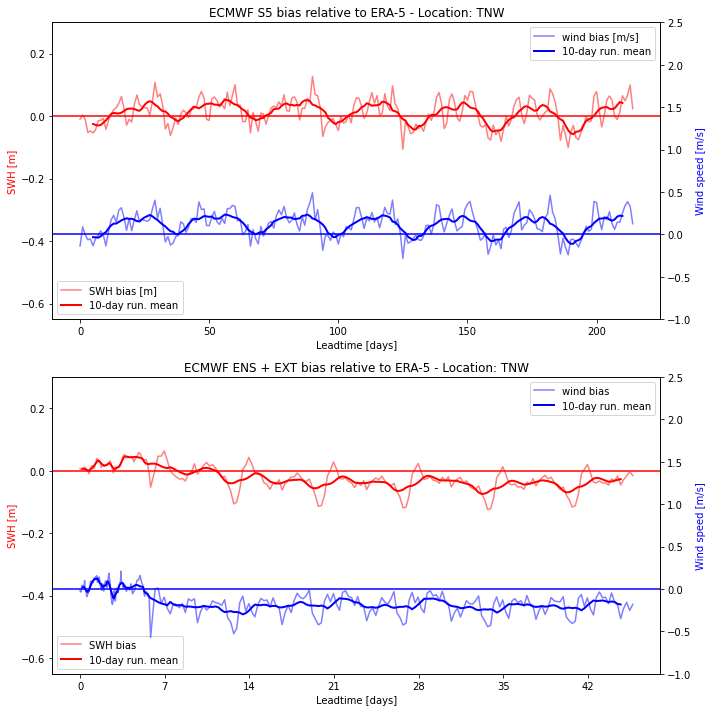

In [17]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
loc='TNW'
timez = pd.to_datetime(bias_s5.step.values + bias_s5.time[0].values)
tmp1 = bias_s5.mean(dim='time').sel(loc=loc).assign_coords(step=np.arange(215))
tmp2 = bias_s5_rm.mean(dim='time').sel(loc=loc).assign_coords(step=np.arange(215))

ax1b = ax1.twinx()
ax1.axhline(0,color='r')
ax1b.axhline(0,color='b')

tmp1.swh.plot(ax=ax1,label='SWH bias [m]',color='r',alpha=0.5)
tmp1.swh.rolling(step=10,center=True).mean().plot(ax=ax1,color='r',lw=2,label='10-day run. mean')

tmp1.wind.plot(ax=ax1b,label='wind bias [m/s]',color='b',alpha=0.5)
tmp1.wind.rolling(step=10,center=True).mean().plot(ax=ax1b,color='b',lw=2,label='10-day run. mean')


timez = pd.to_datetime(bias_ext.step.values + pd.to_datetime('01-01-1985'))
tmp1 = bias_ext.mean(dim='time').sel(loc=loc)#.assign_coords(step=timez)
tmp2 = bias_ext_rm.mean(dim='time').sel(loc=loc)#.assign_coords(step=timez)

ax2b = ax2.twinx()
ax2.axhline(0,color='r')
ax2b.axhline(0,color='b')
tmp1.swh.plot(ax=ax2,label='SWH bias',color='r',alpha=0.5)
tmp1.swh.rolling(step=10,center=True).mean().plot(ax=ax2,color='r',lw=2,label='10-day run. mean')

tmp1.wind.plot(ax=ax2b,label='wind bias',color='b',alpha=0.5)
tmp1.wind.rolling(step=10,center=True).mean().plot(ax=ax2b,color='b',lw=2,label='10-day run. mean')

ax1b.set_title('')
ax1.set_title('ECMWF S5 bias relative to ERA-5 - Location: TNW')
ax2b.set_title('')
ax2.set_title('ECMWF ENS + EXT bias relative to ERA-5 - Location: TNW')
ax1.set_ylabel('SWH [m]',color='red')
ax2.set_ylabel('SWH [m]',color='red')
ax1b.set_ylabel('Wind speed [m/s]',color='blue')
ax2b.set_ylabel('Wind speed [m/s]',color='blue')


ax1.set_xlabel("Leadtime [days]")
ax2.set_xlabel("Leadtime [days]")

ax1.legend(loc=3)
ax1b.legend(loc=1)
ax1.set_ylim([-0.65,0.3])
ax1b.set_ylim([-1,2.5])
ax2.legend(loc=3)
ax2b.legend(loc=1)
# Set xticks, units in nanoseconds
ticks = np.array([0,7,14,21,28,35,42])
ax2.set_xticks(ticks*24*3600*1e9)
ax2.set_xticklabels(ticks.astype(int))
ax2.set_ylim([-0.65,0.3])
ax2b.set_ylim([-1,2.5])
plt.tight_layout()
plt.savefig(bdf+'biad_leadtime_ref_era5.png',dpi=1000)
plt.show()

To conclude from this figure: There are two things that stand out from this figure. First, there is quite a large bias in both S5 and extended range. We need to correct for this. Secondly, both S5 and extended range have a clear monthly / weekly signal in the bias. We need to find out what this is.

#### 3.2.2 Bias as function of start month

/tmp/ipykernel_14233/1124079908.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=0)


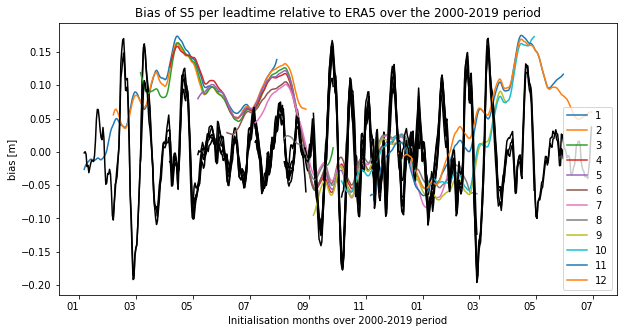

In [18]:
f,ax = plt.subplots(figsize=(10,5))
loc='Borssele'
bias_s5_pm_test = bias_s5_test.groupby('time.month').mean('time')
for m in bias_s5_pm.month:
    bias_s5_pm.swh.sel(month=m,loc=loc).assign_coords(step=pd.date_range('2000-'+str(m.values).zfill(2)+'-01',freq='D',periods=215)).rolling(step=10,center=True).mean().plot(ax=ax,label=m.values)
    bias_s5_pm_test.swh.sel(loc=loc).sel(month=m).assign_coords(step=pd.date_range('2000-'+str(m.values).zfill(2)+'-01',freq='D',periods=215)).rolling(step=10,center=True).mean().plot(ax=ax,color='k')
ax.legend(loc=4)
ax.set_title('Bias of S5 per leadtime relative to ERA5 over the 2000-2019 period')
ax.set_ylabel('bias [m]')
ax.set_xlabel('Initialisation months over 2000-2019 period')
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
plt.savefig(bdf+'bias_time_ref_era5.png')
plt.show()

/tmp/ipykernel_14233/2807993181.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=0)


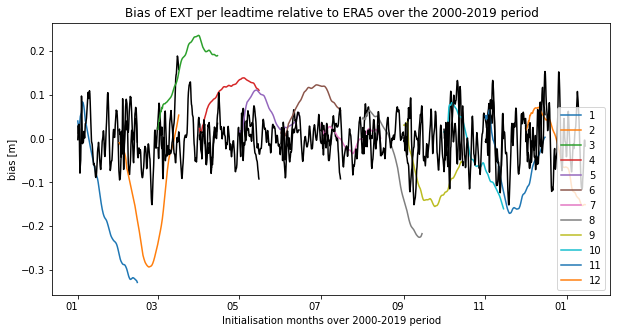

In [19]:
f,ax = plt.subplots(figsize=(10,5))
loc='Borssele'
bias_ext_pm_test = bias_ext_test.groupby('time.month').mean('time')
step = valid_timez_ext[0]-valid_timez_ext[0][0]
for m in bias_ext_pm.month:
    timez=step+pd.date_range('2000-'+str(m.values).zfill(2)+'-01',freq='D',periods=1).values
    bias_ext_pm.swh.sel(month=m,loc=loc).assign_coords(step=timez[:-1]).rolling(step=10,center=True).mean().plot(ax=ax,label=m.values)
    bias_ext_pm_test.swh.sel(loc=loc).sel(month=m).assign_coords(step=timez[:-1]).rolling(step=10,center=True).mean().plot(ax=ax,color='k')
ax.legend(loc=4)
ax.set_title('Bias of EXT per leadtime relative to ERA5 over the 2000-2019 period')
ax.set_ylabel('bias [m]')
ax.set_xlabel('Initialisation months over 2000-2019 period')

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
plt.savefig(bdf+'bias_leadtime_startmonths_ext_ref_era5.png')
plt.show()

To conclude from this figure: Again the monthly cycles are clearly visible in the figure, mainly in spring and autumn. The bias correction (black line) seems to work, given that as designed the bias is 0 after bias correction

#### 3.3 Assess why the weakly and monthly cycles?

#### 3.3.1 Climatolgy

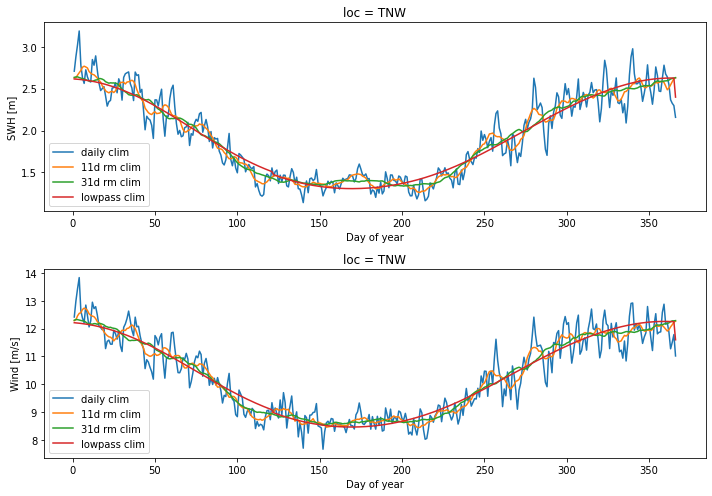

In [20]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(10,7))
loc=5
loc='TNW'
def clim_rm(ds,dayz):
    return ds.groupby('time.dayofyear').mean('time').pad(dayofyear=dayz//2,mode='wrap').rolling(dayofyear=dayz,center=True).mean()
for ax,var in zip([ax1,ax2],['swh','wind']):
    era5_wp_dmax[var].groupby('time.dayofyear').mean().sel(loc=loc).plot(label='daily clim',ax=ax)
    clim_rm(era5_wp_dmax[var].sel(loc=loc),11).plot(label='11d rm clim',ax=ax)
    #clim_rm(era5_wp_dmax[var].isel(loc=loc),21).plot(label='21d rm clim',ax=ax)
    clim_rm(era5_wp_dmax[var].sel(loc=loc),31).plot(label='31d rm clim',ax=ax)
    #era5_wp_dm = era5_wp[var].resample(time='D').max()
    tmp = era5_wp_dmax.assign_coords(time=np.arange(len(era5_wp_dmax.time)))
    lp_swh = dsp.lowpass(tmp[var].sel(loc=loc),1./150.,dim='time')
    lp_swh = lp_swh.assign_coords(time=era5_wp_dmax.time)
    swh_era5_lp_clim = lp_swh.sel(time=slice('1982','2020')).groupby('time.dayofyear').mean()
    swh_era5_lp_clim.plot(label='lowpass clim',ax=ax)
    ax.legend()
ax1.set_ylabel('SWH [m]')
ax2.set_ylabel('Wind [m/s]')
ax1.set_xlabel('Day of year')
ax2.set_xlabel('Day of year')
plt.tight_layout()
plt.savefig(bdf+'climatologies_era5_smoothed.png',dpi=1000)

To conclude from this figure: The 11-day smoothed ERA5 climatology of SWH and wind shows some clear monthly'ish cycles in spring and autumn. Apparently, an 11-day smoothing on 40 year daily climatology data is not enough to smooth out the large intra-annual variability. Both the 21-day and 31-day also show this signal, and also not really a clear smooth climatology as expected. A possible better way to get a smooth climatology is to base the climatology on the lowpass filtered (here 150 days) data. This gives a smoother climatology. Given that the S5 and EXT are based on large ensemble, we expect a better sampling of the real (model) climatology, hence no wobbles in their data (checked this, indeed no wobbles). A better sampling of the climatology would thus remove these monthly cycles from the bias  

#### 3.3.2 Improved climatological signal

To improve the climatology of ERA5, we use the lowpassed climatological signal as the mean climatology. In order to acquire the disbtribution around the mean per day, we randomly sample from the anomalies relative to the 11-day smoothed climatology, in a 30 day window (+ and - 15 days). This should generally widen the distribution and smooth the mean climatology, without having to make any assumption about the shape of the distribtuions. 

In [21]:
nr_days = 15

era5_anom_ref = (era5_wp_dmax.groupby('time.dayofyear') - clim_rm(era5_wp_dmax,11).dropna('dayofyear',how='all')).set_index(x=["time", "dayofyear"]).sel(time=slice('1981','2019'))

lp_swh = dsp.lowpass(era5_wp_dmax.swh.assign_coords(time=np.arange(len(era5_wp_dmax.time))),1./150.,dim='time')
lp_swh = lp_swh.assign_coords(time=era5_wp_dmax.time)
swh_era5_lp_clim = lp_swh.sel(time=slice('1981','2020')).groupby('time.dayofyear').mean()

lp_wind = dsp.lowpass(era5_wp_dmax.wind.assign_coords(time=np.arange(len(era5_wp_dmax.time))),1./150.,dim='time')
lp_wind = lp_wind.assign_coords(time=era5_wp_dmax.time)
wind_era5_lp_clim = lp_wind.sel(time=slice('1981','2020')).groupby('time.dayofyear').mean()

doys = era5_anom_ref.dayofyear.values
for d,doy in enumerate(np.arange(1,367)):
    if doy < nr_days:
        dayz = ((doys<doy+nr_days) | (doys>366-nr_days+doy))
    elif doy > 366-nr_days:
        dayz = ((doys<np.abs(366-doy-nr_days)) | (doys>366-(366-doy)))
    else:
        dayz = (doys > doy-nr_days) & (doys < doy+nr_days)
    sample = era5_anom_ref.sel(dayofyear=dayz)
    subset = np.random.choice(range(len(sample.dayofyear)),500,replace=True)
    tmp_swh = sample.swh[subset,:].rename({'dayofyear':'number'}).assign_coords(number=range(500)).assign_coords(dayofyear=doy)
    tmp_wind = sample.wind[subset,:].rename({'dayofyear':'number'}).assign_coords(number=range(500)).assign_coords(dayofyear=doy)
    if doy == 1:
        clim_era_anom_swh = tmp_swh
        clim_era_anom_wind = tmp_wind
    else:
        clim_era_anom_swh = xr.concat([clim_era_anom_swh,tmp_swh],dim='dayofyear')
        clim_era_anom_wind = xr.concat([clim_era_anom_wind,tmp_wind],dim='dayofyear')
        
clim_era_swh = clim_era_anom_swh + swh_era5_lp_clim
clim_era_wind = clim_era_anom_wind + wind_era5_lp_clim

Save climatologies to netcdf for application

In [22]:
clim_era_swh.quantile([0.05,0.5,0.95],dim='number').to_netcdf(bd_app+'era5_clim_swh_qt.nc')
clim_era_wind.quantile([0.05,0.5,0.95],dim='number').to_netcdf(bd_app+'era5_clim_wind_qt.nc')
#subset = np.random.choice(range(500,51,replace=True)
clim_era_swh.to_netcdf(bd_app+'era5_clim_swh_doy.nc')
clim_era_wind.to_netcdf(bd_app+'era5_clim_wind_doy.nc')

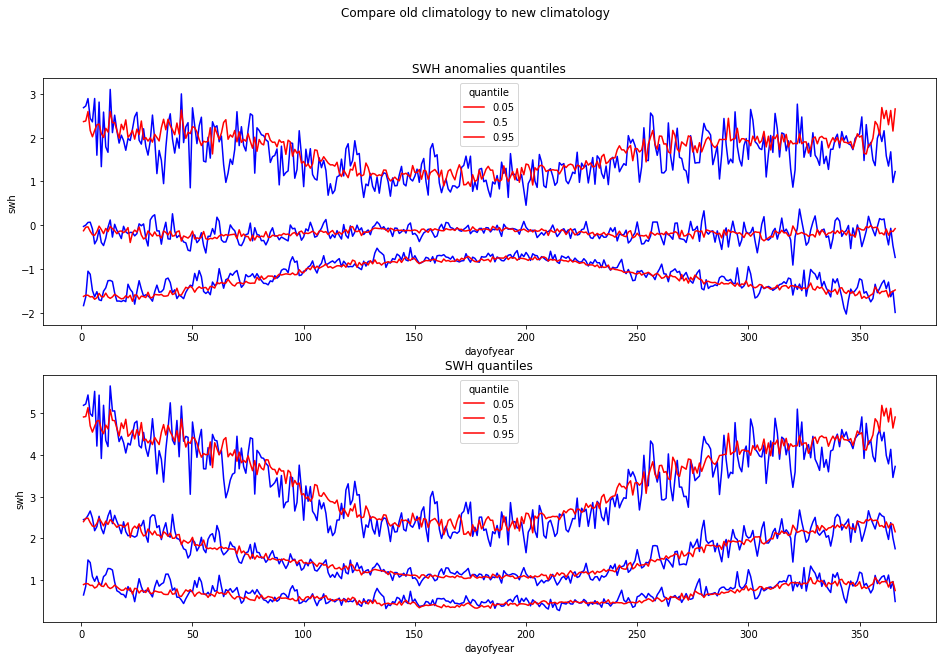

In [23]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
loc=1
clim_era = clim_rm(era5_wp_dmax[var].isel(loc=loc),11)

era5_anom_ref.swh.isel(loc=loc).groupby('dayofyear').quantile([0.05,0.5,0.95],dim='dayofyear').plot(ax=ax1,hue='quantile',color='b')
clim_era_anom_swh.isel(loc=loc).quantile([0.05,0.5,0.95],dim='number').plot(ax=ax1,hue='quantile',color='r')

era5_wp_dmax.swh.isel(loc=loc).groupby('time.dayofyear').quantile([0.05,0.5,0.95],dim='time').plot(ax=ax2,hue='quantile',color='b')
clim_era_swh.isel(loc=loc).quantile([0.05,0.5,0.95],dim='number').plot(ax=ax2,hue='quantile',color='r')
ax1.set_title('SWH anomalies quantiles')
ax2.set_title('SWH quantiles')
plt.suptitle('Compare old climatology to new climatology')
plt.show()

The enhanced climatology seems to perform quite well, with smoother percentiles and less wobbles

TODO: Check why the 0.5 quantile goes up at the end of the year..

### 4 Calculate the skill scores - CRPSS

Function to compute the CRPSS

In [24]:
def f_crps(data,obs,ref=None,ens_axis=1,mean=False):
    crps_fc = ps.crps_ensemble(obs,data,axis=ens_axis)
    if ref is not None: crps_ref = ps.crps_ensemble(obs,ref,axis=ens_axis)
    if mean:
        crps_fc = np.nanmean(crps_fc,axis=0)
        crps_ref = np.nanmean(crps_ref,axis=0)
    if ref is not None: return 1. - (crps_fc / crps_ref)
    else: return crps_fc 

#### 4.1 CRPSS ECMWF S5

In [25]:
def clim(self,nr_ens):
    subset = np.random.choice(range(len(self.time)),nr_ens,replace=True)
    test2 = self[subset,:].assign_coords(time=np.arange(nr_ens)).rename({'time':'number'})
    return test2
era5_swh_climfc_s5 = era5_wp_dmax.swh.groupby('time.dayofyear').apply(clim,nr_ens=len(swh_s5.number))
era5_wind_climfc_s5 = era5_wp_dmax.wind.groupby('time.dayofyear').apply(clim,nr_ens=len(swh_s5.number))

In [26]:
swh_s5_crpss = np.full((len(swh_s5_max.time),len(swh_s5_max.step),10),np.nan)
swh_s5_crpss_nc = np.full_like(swh_s5_crpss,np.nan)
wind_s5_crpss = np.full_like(swh_s5_crpss,np.nan)
wind_s5_crpss_nc = np.full_like(swh_s5_crpss,np.nan)

for i,(t,vt) in enumerate(zip(swh_s5_max.time,valid_timez_s5)):
    vt = vt[:-1] # Remove last day of forecast
    try: # Add try because the forecasts contain future data while ERA5 does not, catch this error
        era5_swh_ss = era5_wp_dmax.swh.sel(time=vt).values
        era5_wind_ss = era5_wp_dmax.wind.sel(time=vt).values
    except KeyError: 
        continue
    
    clim_swh_ss = era5_swh_climfc_s5.sel(dayofyear=pd.to_datetime(vt).dayofyear).transpose('dayofyear','number','loc').values
    clim_wind_ss = era5_wind_climfc_s5.sel(dayofyear=pd.to_datetime(vt).dayofyear).transpose('dayofyear','number','loc').values
    subset = np.random.choice(500,51,replace=True)
    clim_swh_ss_smooth = clim_era_swh.sel(dayofyear=pd.to_datetime(vt).dayofyear).transpose('dayofyear','number','loc').values[:,subset,:]
    clim_wind_ss_smooth = clim_era_wind.sel(dayofyear=pd.to_datetime(vt).dayofyear).transpose('dayofyear','number','loc').values[:,subset,:]
    s5_swh_ss = swh_s5_max.swh.sel(time=t).transpose('step','number','loc').values
    s5_swh_bc_ss = swh_s5_max_bc.swh.sel(time=t).transpose('step','number','loc').values
    s5_wind_ss = swh_s5_max.wind.sel(time=t).transpose('step','number','loc').values
    s5_wind_bc_ss = swh_s5_max_bc.wind.sel(time=t).transpose('step','number','loc').values
    
    # Calculate CRPSS
    swh_s5_crpss[i,:] = f_crps(s5_swh_ss,era5_swh_ss,ref=clim_swh_ss_smooth)
    swh_s5_crpss_nc[i,:] = f_crps(s5_swh_ss,era5_swh_ss,ref=clim_swh_ss)
    wind_s5_crpss[i,:] = f_crps(s5_wind_ss,era5_wind_ss,ref=clim_wind_ss_smooth)
    wind_s5_crpss_nc[i,:] = f_crps(s5_wind_ss,era5_wind_ss,ref=clim_wind_ss)
    
    #swh_s5_crpss_bc_nc[i,:] = f_crps(s5_bc_ss,era5_ss,ref=clim_ss_nc)

swh_s5_crpss_ds = xr.DataArray(swh_s5_crpss, coords=[ 
                                                    ('time', swh_s5_max.time.values),
                                                    ('step',swh_s5_max.step.values),
                                                    ('loc',swh_s5_max['loc'].values)],
                        ).to_dataset(name='swh')

swh_s5_crpss_ds['swh_nc'] = (('time','step','loc'),swh_s5_crpss_nc)
swh_s5_crpss_ds['wind'] = (('time','step','loc'),wind_s5_crpss)
swh_s5_crpss_ds['wind_nc'] = (('time','step','loc'),wind_s5_crpss_nc)
# take last 20 years to calculate the crpss
swh_s5_crpss_ds.sel(time=slice('2000',None)).mean(dim='time').to_netcdf(bd_app+'swh_s5_crpss_refclim.nc')

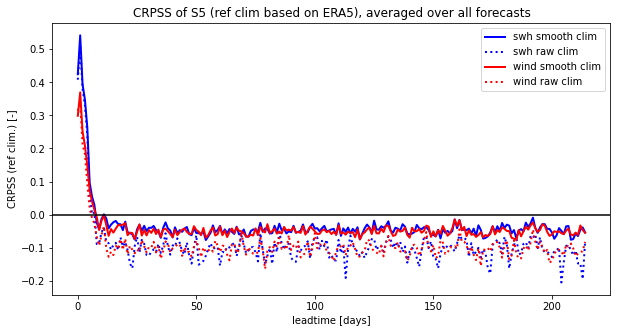

In [27]:
plt.figure(figsize=(10,5))
swh_s5_crpss_ds.swh.mean(dim=['time','loc']).assign_coords(step=np.arange(215)).plot(lw=2,label='swh smooth clim',color='b')
swh_s5_crpss_ds.swh_nc.mean(dim=['time','loc']).assign_coords(step=np.arange(215)).plot(lw=2,label='swh raw clim',color='b',ls=':')
swh_s5_crpss_ds.wind.mean(dim=['time','loc']).assign_coords(step=np.arange(215)).plot(lw=2,label='wind smooth clim',color='r')
swh_s5_crpss_ds.wind_nc.mean(dim=['time','loc']).assign_coords(step=np.arange(215)).plot(lw=2,label='wind raw clim',color='r',ls=':')
plt.axhline(0,color='k')
#swh_s5_crpss_ds.swh_bc_nc.mean(dim=['time','loc']).assign_coords(step=np.arange(216)).plot(color='b',lw=2,label='bc nc')
plt.title('CRPSS of S5 (ref clim based on ERA5), averaged over all forecasts')
plt.ylabel('CRPSS (ref clim.) [-]')
plt.xlabel('leadtime [days]')
plt.legend()
plt.savefig(bdf+'crpss_s5_leadtime.png',dpi=1000)
plt.show()

#### 4.2 CRPSS ECMWF Extended range 

First create climatology forecast by randomly selecting 51 values from all hourly data per dayofyear.

In [28]:
def clim(self,nr_ens):
    subset = np.random.choice(range(len(self.time)),nr_ens,replace=True)  
    test2 = self[subset,:].assign_coords(time=np.arange(nr_ens)).rename({'time':'number'})
    return test2

era5_swh_climfc_ext = era5_wp_dmax.swh.groupby('time.dayofyear').apply(clim,nr_ens=len(swh_ext.number))
era5_wind_climfc_ext = era5_wp_dmax.wind.groupby('time.dayofyear').apply(clim,nr_ens=len(swh_ext.number))

Now calculate the crpss

In [29]:
swh_ext_crpss = np.full((len(swh_ext_max.time),len(swh_ext_max.step),10),np.nan)
swh_ext_crpss_nc = np.full_like(swh_ext_crpss,np.nan)
wind_ext_crpss = np.full_like(swh_ext_crpss,np.nan)
wind_ext_crpss_nc = np.full_like(swh_ext_crpss,np.nan)

for i,(t,vt) in enumerate(zip(swh_ext_max.time,valid_timez_ext)):
    vt = vt[:-1] # Remove last day of forecast
    #print(i)
    try: # Add try because the forecasts contain future data while ERA5 does not, catch this error
        era5_ss_swh = era5_ext.swh.sel(time=t).values.T
        era5_ss_wind = era5_ext.wind.sel(time=t).values.T
    except KeyError:
        #print(i)
        continue
    clim_ss_swh = era5_swh_climfc_ext.sel(dayofyear=pd.to_datetime(vt).dayofyear).transpose('dayofyear','number','loc').values
    clim_ss_wind = era5_wind_climfc_ext.sel(dayofyear=pd.to_datetime(vt).dayofyear).transpose('dayofyear','number','loc').values
    subset = np.random.choice(500,51,replace=True)
    clim_ss_swh_smooth = clim_era_swh.sel(dayofyear=pd.to_datetime(vt).dayofyear).transpose('dayofyear','number','loc').values[:,subset,:]
    clim_ss_wind_smooth = clim_era_wind.sel(dayofyear=pd.to_datetime(vt).dayofyear).transpose('dayofyear','number','loc').values[:,subset,:]
    ext_ss_swh = swh_ext_max.swh.sel(time=t).transpose('step','number','loc').values
    ext_ss_wind = swh_ext_max.wind.sel(time=t).transpose('step','number','loc').values
    ext_bc_swh_ss = swh_ext_max_bc.swh.sel(time=t).transpose('step','number','loc').values
    ext_bc_wind_ss = swh_ext_max_bc.wind.sel(time=t).transpose('step','number','loc').values
    # Calculate CRPSS
    # Use bias corrected data
    swh_ext_crpss[i,:] = f_crps(ext_bc_swh_ss,era5_ss_swh,ref=clim_ss_swh_smooth)
    swh_ext_crpss_nc[i,:] = f_crps(ext_bc_swh_ss,era5_ss_swh,ref=clim_ss_swh)
    wind_ext_crpss[i,:] = f_crps(ext_bc_wind_ss,era5_ss_wind,ref=clim_ss_wind_smooth)
    wind_ext_crpss_nc[i,:] = f_crps(ext_bc_wind_ss,era5_ss_wind,ref=clim_ss_wind)
    

swh_ext_crpss_ds = xr.DataArray(swh_ext_crpss, coords=[ 
                                                    ('time', swh_ext_max.time.values),
                                                    ('step',swh_ext_max.step.values),
                                                    ('loc',swh_ext_max['loc'].values)],
                        ).to_dataset(name='swh')
swh_ext_crpss_ds['swh_nc'] = (('time','step','loc'),swh_ext_crpss_nc)
swh_ext_crpss_ds['wind'] = (('time','step','loc'),wind_ext_crpss)
swh_ext_crpss_ds['wind_nc'] = (('time','step','loc'),wind_ext_crpss_nc)
# take last 20 years to calculate the crpss
swh_ext_crpss_ds.mean(dim='time').to_netcdf(bd_app+'swh_ext_crpss_refclim.nc')

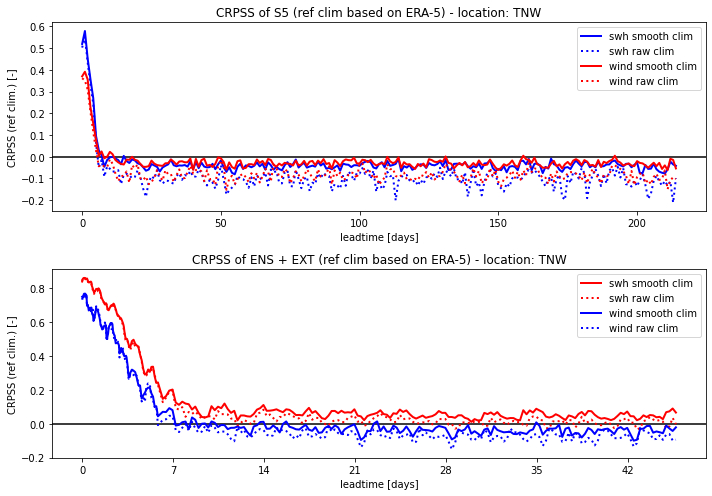

In [30]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(10,7))
loc='Borssele'
loc = 'TNW'

#plt.figure(figsize=(10,5))
ax1.axhline(0,color='k')
swh_s5_crpss_ds.swh.mean(dim='time').sel(loc=loc).assign_coords(step=np.arange(215)).plot(ax=ax1,lw=2,label='swh smooth clim',color='b')
swh_s5_crpss_ds.swh_nc.mean(dim='time').sel(loc=loc).assign_coords(step=np.arange(215)).plot(ax=ax1,lw=2,label='swh raw clim',color='b',ls=':')
swh_s5_crpss_ds.wind.mean(dim='time').sel(loc=loc).assign_coords(step=np.arange(215)).plot(ax=ax1,lw=2,label='wind smooth clim',color='r')
swh_s5_crpss_ds.wind_nc.mean(dim='time').sel(loc=loc).assign_coords(step=np.arange(215)).plot(ax=ax1,lw=2,label='wind raw clim',color='r',ls=':')
#swh_s5_crpss_ds.swh_bc_nc.mean(dim=['time','loc']).assign_coords(step=np.arange(216)).plot(color='b',lw=2,label='bc nc')
ax1.set_title('CRPSS of S5 (ref clim based on ERA-5) - location: TNW')
ax1.set_ylabel('CRPSS (ref clim.) [-]')
ax1.set_xlabel('leadtime [days]')
ax1.legend()

ax2.axhline(0,color='k')
swh_ext_crpss_ds.swh.mean(dim='time').sel(loc=loc).plot(ax=ax2,color='r',lw=2,label='swh smooth clim')
swh_ext_crpss_ds.swh_nc.mean(dim='time').sel(loc=loc).plot(ax=ax2,color='r',lw=2,ls=':',label='swh raw clim')

swh_ext_crpss_ds.wind.mean(dim='time').sel(loc=loc).plot(ax=ax2,color='b',lw=2,label='wind smooth clim')
swh_ext_crpss_ds.wind_nc.mean(dim='time').sel(loc=loc).plot(ax=ax2,color='b',lw=2,ls=':',label='wind raw clim')

#swh_s5_crpss_ds.swh_bc_nc.mean(dim=['time','loc']).assign_coords(step=np.arange(216)).plot(color='b',lw=2,label='bc nc')
ax2.set_title('CRPSS of ENS + EXT (ref clim based on ERA-5) - location: TNW')
ax2.set_ylabel('CRPSS (ref clim.) [-]')
ax2.set_xlabel('leadtime [days]')

ax2.legend()

# Set xticks, units in nanoseconds
ticks = np.array([0,7,14,21,28,35,42])
ax2.set_xticks(ticks*24*3600*1e9)
ax2.set_xticklabels(ticks.astype(int))
plt.tight_layout()
plt.savefig(bdf+'crpss_leadtime_biascorrect.png',dpi=1000)
plt.show()